In [1]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.



 Dataset Summary 
       Intern_ID  Task_Completion_Time  Feedback_Rating  Attendance  \
count   9.000000              9.000000         9.000000    9.000000   
mean    5.000000              6.144444         7.177778   87.777778   
std     2.738613              1.422244         1.326441    6.016182   
min     1.000000              4.200000         5.200000   77.000000   
25%     3.000000              5.100000         6.100000   85.000000   
50%     5.000000              6.300000         7.000000   88.000000   
75%     7.000000              6.800000         8.000000   91.000000   
max     9.000000              8.400000         9.100000   96.000000   

       Performance_Score  
count           9.000000  
mean           76.666667  
std            10.641898  
min            60.000000  
25%            70.000000  
50%            75.000000  
75%            85.000000  
max            92.000000  


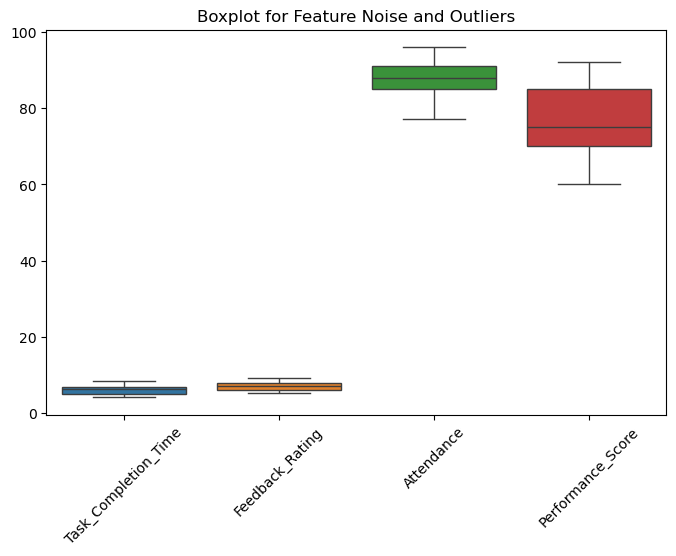

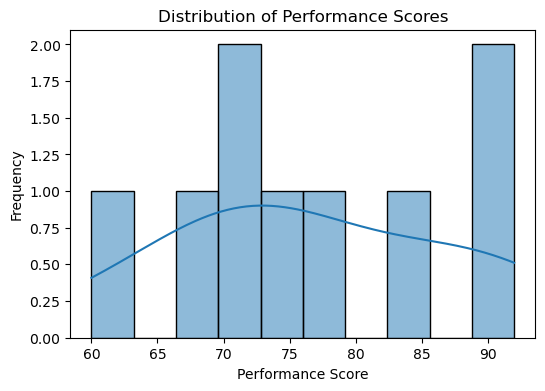

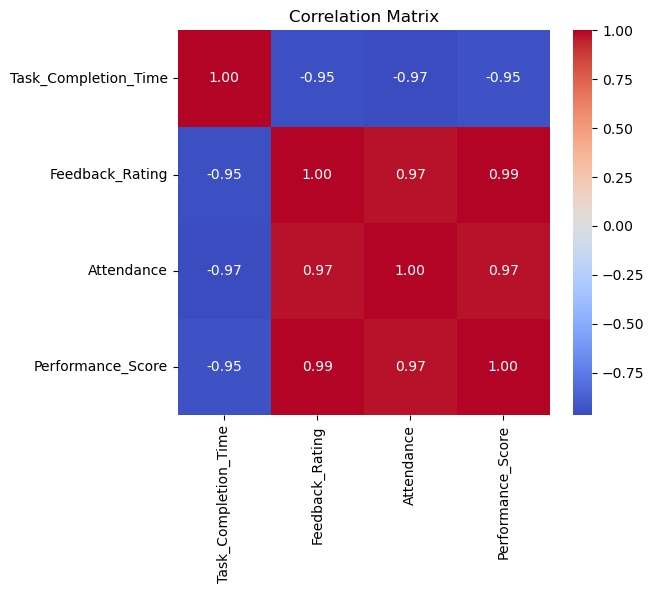


--- Random Forest Evaluation ---
R2 Score: 0.8753819444444447
MAE: 1.9549999999999983
RMSE: 2.118076957997511


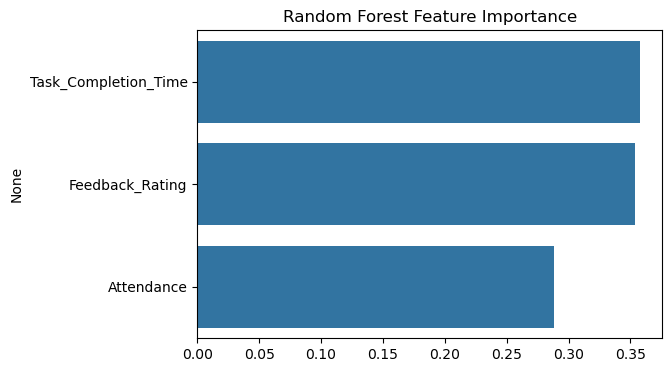


--- XGBoost Evaluation ---
R2 Score: 0.8249577283859253
MAE: 2.4483413696289062
RMSE: 2.5102829905742987


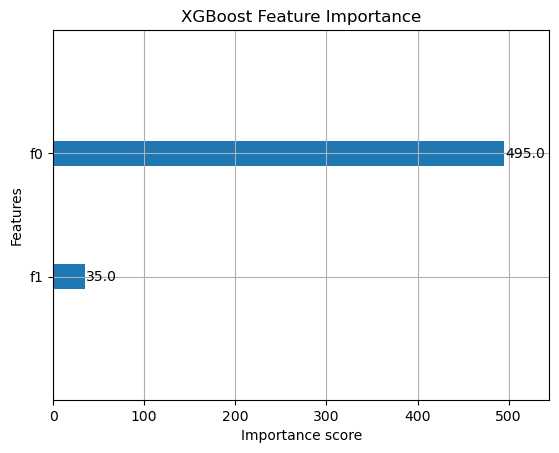


--- Sample Predictions ---
   Task_Completion_Time  Feedback_Rating  Attendance  Performance_Score  \
0                   4.2              9.1          96                 92   
1                   6.5              7.5          88                 78   
2                   5.1              8.0          91                 85   
3                   7.8              6.0          82                 68   
4                   6.3              7.0          89                 75   
5                   5.7              6.8          87                 72   
6                   8.4              5.2          77                 60   
7                   4.5              8.9          95                 90   
8                   6.8              6.1          85                 70   

   rf_predicted_score  xgb_predicted_score Performance_Level  \
0               88.86            91.894135             Excel   
1               75.23            74.997452              Good   
2               81.68        

In [24]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv(r"C:\Users\Dell\Downloads\Intern performance dataset.csv")
df.head()

print("\n Dataset Summary ")
print(df.describe())

# Noise and outlier visualization
plt.figure(figsize=(8, 5))
sns.boxplot(data=df[['Task_Completion_Time', 'Feedback_Rating', 'Attendance', 'Performance_Score']])
plt.title("Boxplot for Feature Noise and Outliers")
plt.xticks(rotation=45)
plt.show()

# Performance distribution
plt.figure(figsize=(6, 4))
sns.histplot(df['Performance_Score'], kde=True, bins=10)
plt.title("Distribution of Performance Scores")
plt.xlabel("Performance Score")
plt.ylabel("Frequency")
plt.show()

# Correlation matrix (excluding Intern_ID)
plt.figure(figsize=(6, 5))
sns.heatmap(df.drop(columns=['Intern_ID']).corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix")
plt.show()

# ------------------ Feature Engineering ------------------
X = df[['Task_Completion_Time', 'Feedback_Rating', 'Attendance']]
y = df['Performance_Score']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ------------------ Random Forest ------------------
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)
rf_preds = rf_model.predict(X_test_scaled)

print("\n--- Random Forest Evaluation ---")
print("R2 Score:", r2_score(y_test, rf_preds))
print("MAE:", mean_absolute_error(y_test, rf_preds))
print("RMSE:", mean_squared_error(y_test, rf_preds, squared=False))

# Feature Importance - Random Forest
plt.figure(figsize=(6, 4))
sns.barplot(x=rf_model.feature_importances_, y=X.columns)
plt.title("Random Forest Feature Importance")
plt.show()

# ------------------ XGBoost ------------------
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train_scaled, y_train)
xgb_preds = xgb_model.predict(X_test_scaled)

print("\n--- XGBoost Evaluation ---")
print("R2 Score:", r2_score(y_test, xgb_preds))
print("MAE:", mean_absolute_error(y_test, xgb_preds))
print("RMSE:", mean_squared_error(y_test, xgb_preds, squared=False))

# Feature Importance - XGBoost
xgb.plot_importance(xgb_model)
plt.title("XGBoost Feature Importance")
plt.show()

# ------------------ Predict for Full Dataset ------------------
X_scaled_full = scaler.transform(X)
df['rf_predicted_score'] = rf_model.predict(X_scaled_full)
df['xgb_predicted_score'] = xgb_model.predict(X_scaled_full)

# ------------------ Score to Category (Struggle, Good, Excel) ------------------
label_map = {'Low': 'Struggle', 'Average': 'Good', 'High': 'Excel'}

score_bins = [0, 70, 85, 100]
score_labels = ['Low', 'Average', 'High']

# Actual and predicted category labels
df['Performance_Level'] = pd.cut(df['Performance_Score'], bins=score_bins, labels=score_labels).map(label_map)
df['rf_predicted_category'] = pd.cut(df['rf_predicted_score'], bins=score_bins, labels=score_labels).map(label_map)
df['xgb_predicted_category'] = pd.cut(df['xgb_predicted_score'], bins=score_bins, labels=score_labels).map(label_map)

# ------------------ Show Prediction Table ------------------
print("\n--- Sample Predictions ---")
display_cols = ['Task_Completion_Time', 'Feedback_Rating', 'Attendance', 'Performance_Score',
                'rf_predicted_score', 'xgb_predicted_score',
                'Performance_Level', 'rf_predicted_category', 'xgb_predicted_category']

print(df[display_cols].head(10))

# ------------------ Sample Prediction ------------------
sample_input = pd.DataFrame({
    'Task_Completion_Time': [5.0],
    'Feedback_Rating': [8.5],
    'Attendance': [90]
})
sample_scaled = scaler.transform(sample_input)
sample_pred_rf = rf_model.predict(sample_scaled)[0]
sample_pred_xgb = xgb_model.predict(sample_scaled)[0]

print(f"\nSample Prediction (Random Forest): {sample_pred_rf:.2f}")
print(f"Sample Prediction (XGBoost): {sample_pred_xgb:.2f}")

# ------------------ Save Models ------------------
joblib.dump(rf_model, "rf_intern_model.pkl")
joblib.dump(xgb_model, "xgb_intern_model.pkl")
print("\nModels saved successfully!")
